In [1]:
%pylab inline
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import os
import sys
import numpy as np
os.chdir('/u/20/vranoug1/unix/OPM-BCI/mneflow-dev/mneflow/')

import mneflow
from mneflow import keras_models

from mneflow.keras_utils import plot_metrics, plot_output, plot_history_v2
from mneflow.keras_utils import mse_weighted, mae_weighted
from mneflow.keras_utils import r_square, soft_acc, rmse

# Force enable eager execution after importing mneflow
tf.compat.v1.enable_eager_execution()

# Dataset parameters
dpath = '/m/nbe/scratch/strokemotor/healthysubjects/'
# fname = 'sub1/short_epochs.fif'
fnames = [''.join([dpath, 'sub', str(ii), '/long_epochs.fif']) for ii in range(2, 3)]

import_opt = dict(fs=1000,
                  savepath='../tfr/',
                  out_name='stm_seq',
                  input_type='seq',
                  overwrite=False,
                  val_size=0.2,
                  # array_keys={'X': 'train_data', 'y': 'train_dg'},
                  # picks=np.arange(0,306,3),
                  bp_filter=(.1, 125),
                  # target_picks=None,
                  target_type='int',
                  segment=250,
                  augment=True,
                  aug_stride=100,
                  # transpose=('X', 'y'),
                  combine_events={3: 0, 4: 1, 5: 1, 6: 0, 2: 2},
                  scale=True,
                  scale_interval=(0, 1000),
                  decimate=None,
                  # transform_targets=False,
                  seq_length=None,
                  test_set='holdout'
                  )

meta = mneflow.produce_tfrecords(fnames, **import_opt)

nbatch = 12
steps = int(144/nbatch)

# batch the dataset according to that value
dataset = mneflow.Dataset(meta, train_batch=nbatch, class_subset=None,
                          pick_channels=None, decim=None)


Populating the interactive namespace from numpy and matplotlib
Metadata file found, restoring


In [2]:
import sys
sys.path
print('---------\n'+mneflow.__file__)
print('tf version: '+tf.__version__)
print('executing eagerly: '+str(tf.executing_eagerly())+'\n---------')

---------
/u/20/vranoug1/unix/.conda/envs/py3ml/lib/python3.7/site-packages/mneflow/__init__.py
tf version: 1.14.0
executing eagerly: True
---------


In [3]:
# specify optimizer parmeters
optim = tf.keras.optimizers.Adam(learning_rate=3e-4)

# specify model parameters
graph_specs = dict(n_ls=32,  # number of latent factors
                   filter_length=32,  # convolutional filter length
                   pooling=5,  # convlayer pooling factor
                   stride=5,  # stride parameter for pooling layer
                   padding='SAME',
                   dropout=.5,
                   nonlin=tf.nn.relu,
                   pool_type='max',
                   out_dim=np.prod(meta['y_shape']),
                   axis=2,
                   y_shape=meta['y_shape'],
                   model_path=import_opt['savepath'],  # not used at the moment
                   # regularization parameters
                   l1=3e-4,
                   l2=3e-3,
                   # LSTM parameters
                   rnn_units=np.prod(meta['y_shape']),
                   rnn_dropout=0.0,
                   rnn_nonlin='tanh',
                   rnn_rec_nonlin='hard_sigmoid',
                   rnn_forget_bias=True,
                   rnn_seq=True,
                   unroll=False)

model = keras_models.LFLSTM(graph_specs)
loss_f = tf.compat.v1.losses.softmax_cross_entropy  # one-hot labels for classification

# % builtin
model.compile(loss=loss_f, optimizer=optim, metrics=['accuracy'])

de-mix init : OK
lstm init : OK
fc init : OK


In [4]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=5e-6, patience=10)

# %% train the model
history = model.fit(dataset.train, validation_data=dataset.val, epochs=50000,
                    steps_per_epoch=steps, validation_steps=1,
                    callbacks=[stop_early], verbose=1)

Epoch 1/50000
[None, 98, 204, 250]
input x0 (?, 98, 204, 250)
input x0 (?, 1, 204, 250)
de-mix built : OK
dmx (?, 1, 250, 32)
demix dmx (?, 1, 250, 32)
reshaped dmx (?, 250, 32, 1)
conv build : OK
varconv (?, 50, 32, 1)
reshaped varconv (?, 98, 1600)
lstm (?, 98, 32)
(?, 98, 32)
fc ::: 3136 3
fc build : OK
fc y_ (?, 3)
12/12 [==============================] - 93s 8s/step - loss: 4.7336 - acc: 0.2972 - val_loss: 4.0857 - val_acc: 0.5000
Epoch 2/50000
12/12 [==============================] - 113s 9s/step - loss: 4.3091 - acc: 0.4170 - val_loss: 4.0905 - val_acc: 0.3889
Epoch 3/50000
12/12 [==============================] - 113s 9s/step - loss: 4.1863 - acc: 0.4435 - val_loss: 4.4366 - val_acc: 0.2778
Epoch 4/50000
12/12 [==============================] - 115s 10s/step - loss: 4.0755 - acc: 0.5324 - val_loss: 4.4395 - val_acc: 0.1111
Epoch 5/50000
12/12 [==============================] - 114s 9s/step - loss: 4.0915 - acc: 0.4550 - val_loss: 4.6628 - val_acc: 0.2222
Epoch 6/50000
12/12 [==

In [5]:
model.summary()

Model: "lfcnn-lstm"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
de-mix (DeMixing)            multiple                  6560      
_________________________________________________________________
conv (LFTConv)               multiple                  33        
_________________________________________________________________
lstm (LSTMv1)                multiple                  209024    
_________________________________________________________________
fc (Dense)                   multiple                  9411      
Total params: 225,028
Trainable params: 225,028
Non-trainable params: 0
_________________________________________________________________


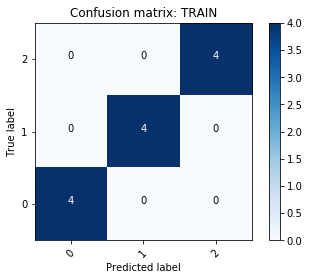

In [6]:
_ = keras_models.plot_cm(model, dataset, 'train', steps=steps)

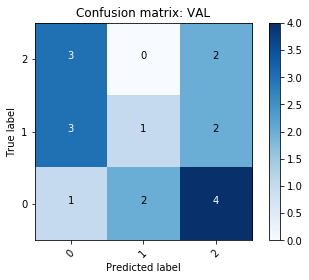

In [7]:
_ = keras_models.plot_cm(model, dataset, 'val', steps=1)

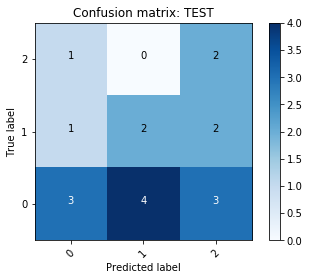

In [8]:
_ = keras_models.plot_cm(model, dataset, 'test', steps=1)